In [1]:
import numpy as np
import torch
import trainlog as trainlog

from discrete_network.network import KNNet, KNNetParameters, KNNetState
from discrete_network.method.force_method import ForceParameters, ForceLearn
from discrete_network.device import device
import matplotlib.pyplot as plt

print(f"Device = {device.type}")

Device = cuda


In [2]:
def one_neuron(x0, y0, iteration, p: KNNetParameters):
    """The dynamics of one neuron. Return x, y."""
    x, y = np.zeros(iteration), np.zeros(iteration)
    x[0], y[0] = x0, y0
    for i in range(iteration - 1):
        x[i + 1] = (
            x[i] + x[i] * (x[i] - p.a) * (1 - x[i]) - p.beta * (x[i] > p.d) - y[i]
        )
        y[i + 1] = y[i] + p.eps * (x[i] - p.J)
    return x, y

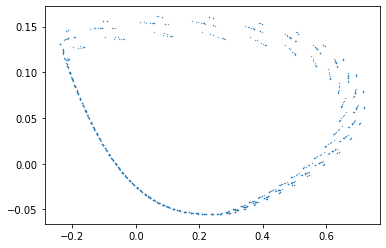

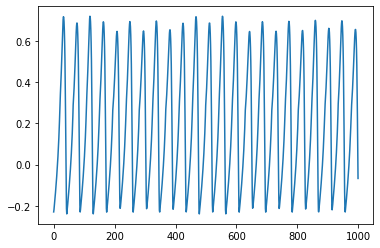

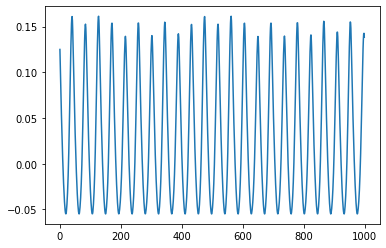

In [3]:
# params_spiking = KNNetParameters(eps = 0.015, beta = 0.0, d = 0.26, a = 0.25, J = 0.1081 + 0.1)
# params_spiking = KNNetParameters(eps = 0.015, beta = 0.03, d = 0.26, a = 0.25, J = 0.1081 + 0.1)
# params_spiking = KNNetParameters(eps=0.035, beta=0.0375, d=0.26, a=0.25, J=0.1081 + 0.1)
params_spiking = KNNetParameters(eps=0.035, beta=0.0375, d=0.26, a=0.25, J=0.1081 + 0.1)
imin = 0
icrit = 20000
nt = 26000
# imin = 0; icrit = 20000; nt = 21000
f_out_x, f_out_y = one_neuron(0.3, 0, nt, params_spiking)
f_out = np.concatenate([[f_out_x], [f_out_y]], 0).T
# print(f_out[-1000:, 1])
%matplotlib inline
plt.figure()
plt.scatter(f_out[-1000:, 0], f_out[-1000:, 1], s=0.1)
plt.show()
plt.close()

plt.figure()
plt.plot(f_out[-1000:, 0])
plt.show()
plt.close()

plt.figure()
plt.plot(f_out[-1000:, 1])
plt.show()
plt.close()

In [4]:
input_size = 0
hidden_size = 2000
output_size = 2

# heterogenious
eps_start = 0.01
eps_stop = 0.1
eps = eps_start + (eps_stop - eps_start) * torch.rand(hidden_size, 1).to(device)
# homogenious
# eps = torch.as_tensor(0.015).to(device)

a = 0.25
# J = (1 + a - torch.sqrt(1 + a * a - a + 3 * eps)) / 3 + 0.01 # Slightly more bifurcation value
J = (1 + a - torch.sqrt(1 + a * a - a + 3 * eps)) / 3
J = J.to(device)

# p = KNNetParameters(eps=eps, J=J)
p = KNNetParameters(
    eps=eps, a=torch.as_tensor(a), J=J, q=1.1, g=0.1, x_th=torch.as_tensor(0.65),
    beta=torch.as_tensor(0.0)
)

x_initial = 0.9 * torch.rand(hidden_size, 1).to(device)
y_initial = torch.zeros(hidden_size, 1).to(device)
z_initial = torch.zeros(hidden_size, 1).to(device)
ISPC_initial = torch.zeros(hidden_size, 1).to(device)
initial_state = KNNetState(x=x_initial, y=y_initial, z=z_initial, ISPC=ISPC_initial)
net = KNNet(input_size, hidden_size, output_size, p=p)
net.to_device(device)
lp = ForceParameters(stop_learning=icrit, start_learning=imin, lr=1e-2)
fl = ForceLearn(net=net, lp=lp, save_states=True)

In [5]:
# train_logs, states = fl.train(target_outputs=f_out, state=initial_state, split_data=0)
train_logs, states = fl.train(target_outputs=f_out, state=initial_state)

100%|██████████| 26000/26000 [00:30<00:00, 839.70it/s] 


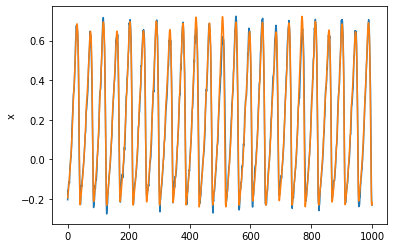

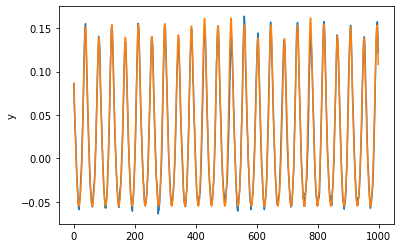

tensor(1.1572, dtype=torch.float64)
tensor(0.1460, dtype=torch.float64)


In [6]:
plt.figure()
plt.plot(train_logs.numpy()[-6000:-5000, 0, 0])
plt.plot(f_out[-6000:-5000, 0])
plt.ylabel("x")
plt.show()
plt.close()

plt.figure()
plt.plot(train_logs.numpy()[-6000:-5000, 1, 0])
plt.plot(f_out[-6000:-5000, 1])
plt.ylabel("y")
plt.show()
plt.close()

L2 = torch.linalg.norm(train_logs[-6000:-5000, 0, 0] - f_out[-6000:-5000, 0])
print(L2)
print(torch.log(L2))

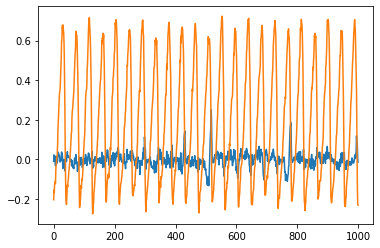

In [7]:
plt.plot(train_logs.numpy()[-6000:-5000, 0, 0] - f_out[-6000:-5000, 0])
plt.plot(train_logs.numpy()[-6000:-5000, 0, 0])

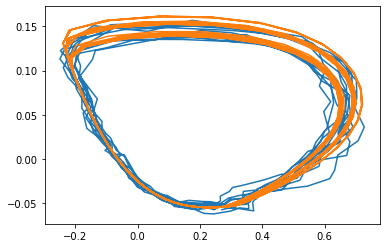

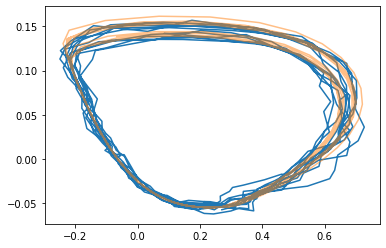

In [8]:
plt.figure()
plt.plot(train_logs.numpy()[-500:, 0, 0], train_logs.numpy()[-500:, 1, 0])
plt.plot(f_out[-1000:, 0], f_out[-1000:, 1])
plt.show()
plt.close()

plt.figure()
plt.plot(train_logs.numpy()[-500:, 0, 0], train_logs.numpy()[-500:, 1, 0])
plt.plot(f_out[-500:, 0], f_out[-500:, 1], alpha=0.5)

plt.show()
plt.close()

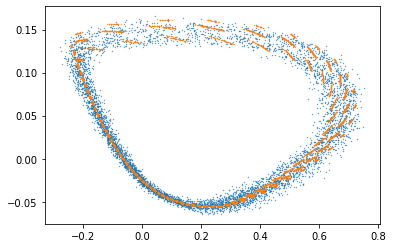

In [9]:
plt.figure()
plt.scatter(train_logs.numpy()[-6000:, 0, 0], train_logs.numpy()[-6000:, 1, 0], s=0.1)
plt.scatter(f_out[-6000:, 0], f_out[-6000:, 1], s=0.1)
plt.show()
plt.close()

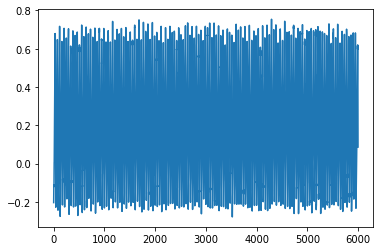

In [10]:
plt.figure()
plt.plot(train_logs.numpy()[-6000:, 0, 0])
# plt.scatter(f_out[-1000:, 0], f_out[-1000:, 1], s=.1)
plt.show()
plt.close()

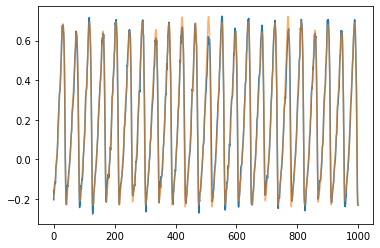

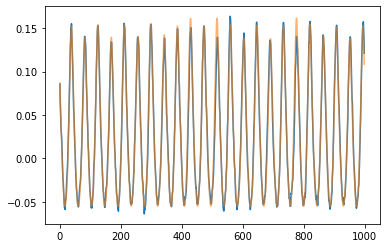

In [11]:
plt.figure()
plt.plot(train_logs.numpy()[-6000:-5000, 0, 0])

plt.plot(f_out[-6000:-5000, 0], alpha=0.6)
plt.show()
plt.close()

plt.figure()
plt.plot(train_logs.numpy()[-6000:-5000, 1, 0])
plt.plot(f_out[-6000:-5000, 1], alpha=0.6)

plt.show()
plt.close()

In [12]:
# plt.plot((train_logs.numpy()[-1000:, 0, 0] - f_out[-1000:, 0]))
# L2 = torch.linalg.norm(train_logs[-1000:, 0, 0] - f_out[-1000:, 0])
# print(L2)
# print(torch.log(L2))

In [13]:
x = []
y = []
for i in range(len(states)):
    x.append(states[i].x)
    y.append(states[i].y)
x = torch.stack(x)
y = torch.stack(y)

x.shape

torch.Size([26000, 2000, 1])

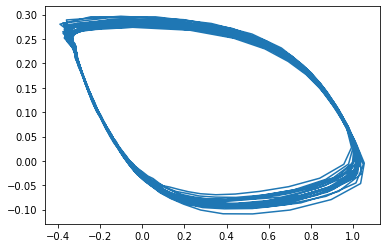

In [14]:
plt.plot(x.numpy()[-1000:, 5], y.numpy()[-1000:, 5])

In [15]:
from discrete_network.pca.pca import PCA

x = x.reshape(*x.shape[0:2])
y = y.reshape(*y.shape[0:2])

pca = PCA(3)

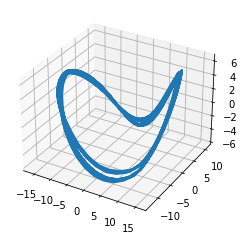

In [16]:
pca_x = pca.decompose(x[-6000:-5000])

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1], pca_x.numpy()[:, 2])
plt.show()
plt.close()

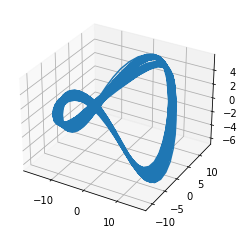

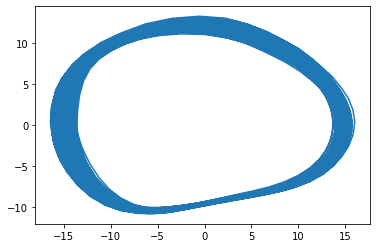

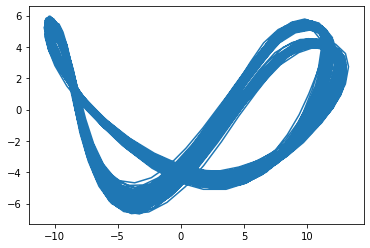

In [17]:
pca_x = pca.decompose(x[-6000:])

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1], pca_x.numpy()[:, 2])
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1])
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(pca_x.numpy()[:, 1], pca_x.numpy()[:, 2])
plt.show()
plt.close()

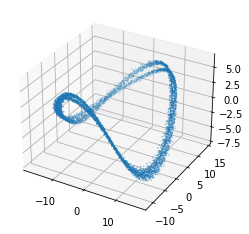

In [18]:
trajectory = torch.concat((x[-6000:], y[-6000:]), axis=1)
pca_traj = pca.decompose(trajectory)

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection="3d")
ax2.scatter(
    pca_traj.numpy()[:, 0], pca_traj.numpy()[:, 1], pca_traj.numpy()[:, 2], s=0.1
)
plt.show()
plt.close()

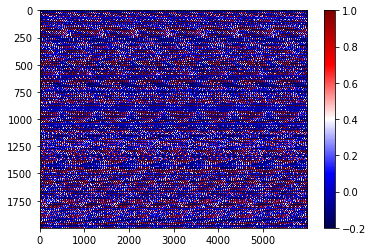

In [19]:
n_neuron = hidden_size

x_np = x.numpy()

fig3 = plt.figure()
plt.imshow(x_np.T[:, -6000:], cmap="seismic", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.show()
plt.close()

In [20]:
from operator import itemgetter

x_th = p.x_th.item()
# x_th = 0.0
# x_th = 0.0
data = x_np
time_start = -6000
# get time index (column) of first spike
first_spike_indexes = []
# print(np.where(data[-1000:, 0] > x_th)[0][0])
for i in range(data.shape[1]):
    spike_times = np.where(data[time_start:, i] > x_th)[0]
    if spike_times.shape[0] == 0:
        first_spike_indexes.append(-time_start)  # max value
    else:
        first_spike_indexes.append(spike_times[0])

# sorted_indexes = ([x for _, x in sorted(zip(first_spike_indexes, [i for i in range(data.shape[1])]))])
x_dict = zip(list(range(data.shape[1])), first_spike_indexes)
x_dict = sorted(x_dict, key=itemgetter(1))
sorted_indexes, _ = zip(*x_dict)

data_sorted = np.zeros_like(data)
for i in range(data.shape[1]):
    data_sorted[:, i] = data[:, sorted_indexes[i]]

len(sorted_indexes) == len(set(sorted_indexes))

True

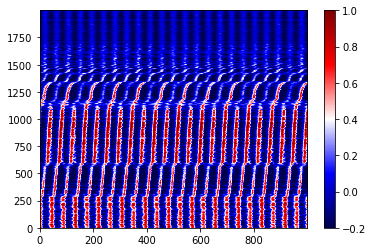

In [21]:
fig4 = plt.figure()
plt.imshow(data_sorted.T[:, -1000:], cmap="seismic", aspect="auto", origin="lower")
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.show()
plt.close()

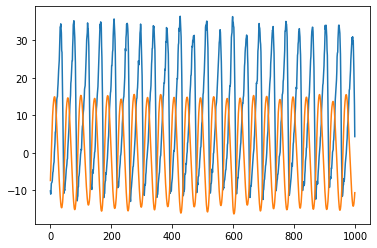

In [22]:
scale = 50
plt.plot(np.arange(1000), train_logs.numpy()[-1000:, 0, 0] * scale)
plt.plot(np.arange(1000), pca_x.numpy()[-1000:, 0])
# plt.plot(x_np[-1000:, 5], x_np[-1000:, 5])
# plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1])
plt.show()
plt.close()

↑
out-t and PCA1_x-t graph

[ 34  77 122 165 209 252 296 338]


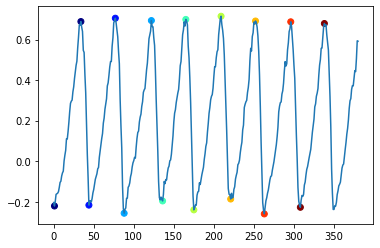

In [23]:
from scipy import signal

output = train_logs.numpy()[-1000:, 0, 0]
spikeid_max = signal.argrelmax(output, order=8)
spikeid_min = signal.argrelmin(output, order=8)

period = 8
start = spikeid_max[0][0]
end = spikeid_max[0][period]
print(np.arange(1000)[spikeid_max][:period])
plt.plot(np.arange(end), output[:end])
plt.scatter(
    [i for i in spikeid_max[0]][:period],
    output[spikeid_max][:period],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.scatter(
    [i for i in spikeid_min[0]][:period],
    output[spikeid_min][:period],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.show()
plt.close()

↑
detecting the spike peak

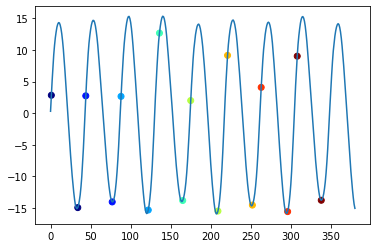

In [24]:
pca_spike_max = pca_x.numpy()[spikeid_max]
pca_spike_min = pca_x.numpy()[spikeid_min]

plt.plot(np.arange(end), pca_x[:end][:, 0])
plt.scatter(
    np.arange(1000)[spikeid_max][:period],
    pca_spike_max[:period][:, 0],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.scatter(
    np.arange(1000)[spikeid_min][:period],
    pca_spike_min[:period][:, 0],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.show()
plt.close()

pca and it's scatter when the output leaches to  peak

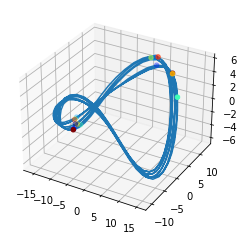

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
pca_spike_max = pca_x.numpy()[spikeid_max][:period]
pca_spike_min = pca_x.numpy()[spikeid_min][:period]
ax.plot(pca_x.numpy()[:, 0][:end], pca_x.numpy()[:, 1][:end], pca_x.numpy()[:, 2][:end])
ax.scatter(
    pca_spike_max[:, 0],
    pca_spike_max[:, 1],
    pca_spike_max[:, 2],
    c=[i for i in range(period)],
    cmap="jet",
)
ax.scatter(
    pca_spike_min[:, 0],
    pca_spike_min[:, 1],
    pca_spike_min[:, 2],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.show()
plt.close()

3d showed figure which is shown in upper cell

In [26]:
# dPCA = np.gradient(pca_x.numpy()[:, 0][:end])
# dPCA_max = np.gradient(pca_spike_max[spikeid_max])
# plt.plot(np.arange(end), pca_x.numpy()[:, 0][:end])
# plt.plot(np.arange(end), dPCA[])
# plt.show()
# plt.close()

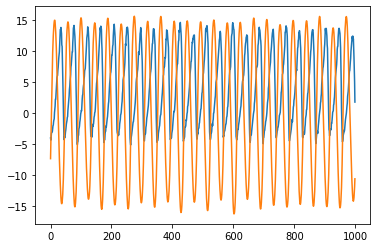

In [27]:
plt.plot(np.arange(1000), train_logs.numpy()[-1000:, 0, 0] * 20)
plt.plot(np.arange(1000), pca_x.numpy()[-1000:, 0])
# plt.plot(x_np[-1000:, 5], x_np[-1000:, 5])
# plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1])
plt.show()
plt.close()

expanded output

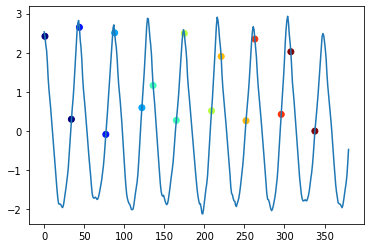

In [28]:
pca_spike = np.gradient(pca_x.numpy()[:, 0])

# plt.plot(np.arange(end), pca_x[:end][:, 0])
plt.plot(np.arange(end), pca_spike[:end])
plt.scatter(
    np.arange(1000)[spikeid_max][:period],
    pca_spike[spikeid_max][:period][:],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.scatter(
    np.arange(1000)[spikeid_min][:period],
    pca_spike[spikeid_min][:period][:],
    c=[i for i in range(period)],
    cmap="jet",
)
plt.show()
plt.close()

derivative of PCA1_x and peak scat

# Save weights

In [29]:
# input_weights - does not matter
w_hidden = net.hidden_weights.cpu().numpy()
w_output = net.output_weights.cpu().numpy()
w_eta = net.eta.cpu().numpy()
np.save("w_hidden", w_hidden)
np.save("w_output", w_output)
np.save("w_eta", w_eta)
p_eps, p_J = p.eps.cpu().numpy(), p.J.cpu().numpy()
np.save('p_eps', p_eps)
np.save('p_J', p_J)